# Prepare

**This notebook are suppose to run in kaggle environment, because the competition is on going, the data for this competition are not suppose to show to non-competition participants.**
</br>
</br>
however you can check the output of the the notebook in **sanity check** session to see the prediction. 
</br>
to run locally, please follow the instruction in **data preparation** session 


In [1]:
# !python -m pip install --no-index --find-links=/kaggle/input/pip-download-for-segmentation-models-pytorch segmentation-models-pytorch
!pip install -q segmentation_models_pytorch

Looking in links: /kaggle/input/pip-download-for-segmentation-models-pytorch
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/segmentation_models_pytorch-0.3.3-py3-none-any.whl
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/pretrainedmodels-0.7.4.tar.gz (from segmentation-models-pytorch)
  Preparing metadata (setup.py) ... - \ done
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/efficientnet_pytorch-0.7.1.tar.gz (from segmentation-models-pytorch)
  Preparing metadata (setup.py) ... - done
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/timm-0.9.2-py3-none-any.whl (from segmentation-models-pytorch)
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/munch-4.0.0-py2.py3-none-any.whl (from pretrainedmodels==0.7.4->segmentation-models-pytorch)
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=59a8150406231ccd2144d7be1

In [2]:
import os
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
from glob import glob
import gc
import time
from collections import defaultdict
import  matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import copy
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch.cuda import amp
import torch.optim as optim
import albumentations as A
import segmentation_models_pytorch as smp

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_msk(path):
    msk = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    msk = msk.astype('float32')
    msk/=255.0
    return msk

In [4]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, msk_paths=[], transforms=None):
        self.img_paths  = img_paths
        self.msk_paths  = msk_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        img = load_img(img_path)
        
        if len(self.msk_paths)>0:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img), torch.tensor(msk)
        else:
            orig_size = img.shape
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img), torch.tensor(np.array([orig_size[0], orig_size[1]]))

# Data preparation 
if you are running locally, please change the data_folder direction to your folder. the code read tif CT images. 

In [5]:
DATASET_FOLDER = "/kaggle/input/blood-vessel-segmentation"
ls_images = glob(os.path.join(DATASET_FOLDER, "test", "*", "images", "*.tif"))
print(f"found images: {len(ls_images)}")

# ===============================================================================
# /kaggle/input/blood-vessel-segmentation/train/kidney_1_dense
# /kaggle/input/blood-vessel-segmentation/train/kidney_2
# sanity check
base_path = '/kaggle/input/blood-vessel-segmentation/train'  
train_base_path = '/kaggle/input/patched-sennet-kidney-1-data'
val_img = "kidney_2"#'kidney_3_sparse',kidney_1_dense
val_mask = "kidney_2"#'kidney_3_sparse',kidney_1_dense

images_val_path = os.path.join(base_path, val_img, 'images')
labels_val_path = os.path.join(base_path, val_mask, 'labels')
image_val_files = sorted([os.path.join(images_val_path, f) for f in os.listdir(images_val_path) if f.endswith('.tif')])
label_val_files = sorted([os.path.join(labels_val_path, f) for f in os.listdir(labels_val_path) if f.endswith('.tif')])

found images: 6


In [6]:
test_dataset = BuildDataset(ls_images, [], transforms=None)
sanity_dataset = BuildDataset(image_val_files,label_val_files,transforms=None )
sanity_loader = DataLoader(sanity_dataset, batch_size = 1, num_workers=0, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size = 1, num_workers=0, shuffle=False, pin_memory=True)

In [7]:
# resnext50_32x4d
# resnet50

#/kaggle/input/resnext-800/best_epoch800.bin
#/kaggle/input/renext-patch-50d/renext_patch.bin
class CFG:
    backbone = "resnext50_32x4d"
    bin_path = '/kaggle/input/resnext-1-2-1-before-final-report/resnext_beforefinalReport_1_2_1.bin'
    test_batchsize = 1
    img_size = [800,800]
    remove_area = 30
    threshold = 0.9
    over_lap = 0.1
    num_classes   = 1
    patch_size = 800
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     data_transforms = {
#         "train": A.Compose([
#             A.Resize(*img_size, interpolation=cv2.INTER_NEAREST),
#             A.HorizontalFlip(p=0.5),
#             A.VerticalFlip(p=0.5),
#         ], p=1.0),
        
#         "valid": A.Compose([
#             A.Resize(*img_size, interpolation=cv2.INTER_NEAREST),
#         ], p=1.0)
#     }
    

# for new way remember to make batch_size to 1

In [8]:
def build_model(backbone, num_classes, device):
    model = smp.Unet(
        encoder_name=backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(device)
    return model

def load_model(backbone, num_classes, device, path):
    model = build_model(backbone, num_classes, device)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = load_model(CFG.backbone, 
                   1, 
                   CFG.device, 
                   CFG.bin_path)

In [10]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    if rle == '':
        rle = '1 0'
    return rle

In [11]:

def remove_small_objects(img, min_size):
    # Find all connected components (labels)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)

    # Create a mask where small objects are removed
    new_img = np.zeros_like(img)
    for label in range(1, num_labels):
        if stats[label, cv2.CC_STAT_AREA] >= min_size:
            new_img[labels == label] = 255

    return new_img

In [12]:
def patch_image(img, patch_size, model = None, over_lap=0.2):
    """
    Splits the image into patches with overlap.

    """
    shape = img.shape

    height, width = shape[2],shape[3]

    stride = patch_size * (1 - over_lap)
    num_patches = np.ceil(np.array([height, width]) / stride).astype(np.int64)
    
    starts = [np.int64(np.linspace(0, width - patch_size, num_patches[1])),
              np.int64(np.linspace(0, height - patch_size, num_patches[0]))]
    patches = []
    for y in starts[1]:
        for x in starts[0]:
            if model != None: 
                patch_img = img[:,:,y:y + patch_size, x:x + patch_size]
#                 print(type(patch_img)," and shape is ",patch_img.shape)
#                 print(f'inside the patch function: size of patched image: {np.shape(patch_img)}')
                patches.append(patch_img)
    patches = torch.cat(patches,dim = 0)
    pred = model(patches)
    return pred


def combine_patches_torch(patches, original_shape, patch_size, over_lap=0.1):
    height, width = original_shape[2],original_shape[3]
    stride = int(patch_size * (1 - over_lap))
    combined = np.zeros((height, width), dtype=np.float32)
    weight = np.zeros((height, width), dtype=np.float32)

    num_patches_y = np.ceil(height / stride).astype(np.int64)
    num_patches_x = np.ceil(width / stride).astype(np.int64)

    starts_y = np.linspace(0, height - patch_size, num_patches_y).astype(np.int64)
    starts_x = np.linspace(0, width - patch_size, num_patches_x).astype(np.int64)

    patch_idx = 0
    for y in starts_y:
        for x in starts_x:
            
            patch = patches[patch_idx].detach().cpu()
            patch = patch.numpy().astype(np.float32)
#             print(f'inside the combine function: type of combine = {type(combined)}, shape of patches = {np.shape(patch)}')
            # with torch, I cannot add different sized tensor together 
            combined[y:y + patch_size, x:x + patch_size] += patch.squeeze()
            weight[y:y + patch_size, x:x + patch_size] += 1.0
            patch_idx += 1

    # Avoid division by zero
    weight[weight == 0] = 1.0
#     combined = combined / weight
    combined = torch.from_numpy(combined)
    combined = combined.unsqueeze(0).unsqueeze(0)
    
    return combined

# inference for resize model

In [13]:
# rles = []
# pbar = tqdm(enumerate(test_loader), total=len(test_loader), desc='Inference ')
# for step, (images, shapes) in pbar:
# #     print(np.shape(images))
#     shapes = shapes.numpy()
#     images = images.to(device, dtype=torch.float)
#     with torch.no_grad():
#         preds = model(images)
#         print(f'shape of raw prediction {np.shape(preds)}')
# #         preds = (nn.Sigmoid()(preds)>0.5).double()
#         preds = (preds>CFG.threshold).float()
#         print(f'shape of prediction after sigmoid {np.shape(preds)}')
#     preds = preds.cpu().numpy().astype(np.uint8)

#     for pred, shape in zip(preds, shapes):
#         pred = cv2.resize(pred[0], (shape[1], shape[0]), cv2.INTER_NEAREST)
#         rle = rle_encode_submission(remove_small_objects(pred,30))
#         rles.append(rle)

# Inference for patch model

In [14]:
rles = []
pbar = tqdm(enumerate(test_loader), total=len(test_loader), desc='Inference ')
for step, (images, shapes) in pbar:
#     print(np.shape(images))
    shapes = shapes.numpy()
    images = images.to(device, dtype=torch.float)
    with torch.no_grad():
        ori_shape = images.shape
#         print(ori_shape)
#         print(np.shape(images))
        patches = patch_image(images,patch_size = CFG.patch_size,model = model,over_lap = CFG.over_lap)
        pred  = combine_patches_torch(patches,ori_shape,patch_size = CFG.patch_size,over_lap = CFG.over_lap )
        pred = pred.cpu().numpy()
        pred = ((pred>CFG.threshold)*255).astype(np.uint8)
    pred = pred.squeeze()
#     print(f'shape of raw prediction {np.shape(pred)}')
    rle = rle_encode(remove_small_objects(pred,CFG.remove_area))
    rles.append(rle)

Inference : 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


# Sanity check

torch.Size([3, 1041, 1511])
torch.Size([6, 1, 800, 800])


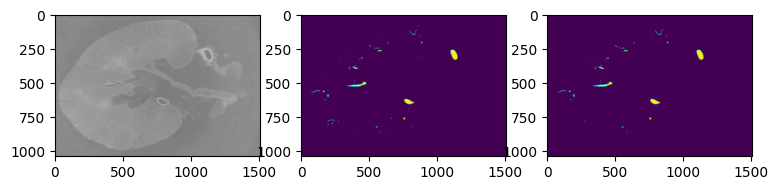

torch.Size([3, 1041, 1511])
torch.Size([6, 1, 800, 800])


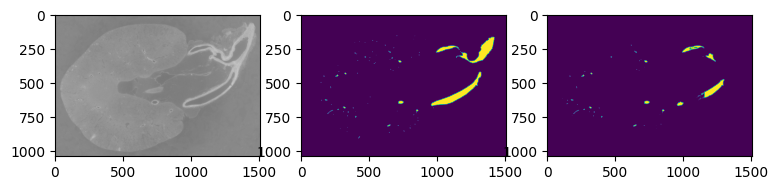

torch.Size([3, 1041, 1511])
torch.Size([6, 1, 800, 800])


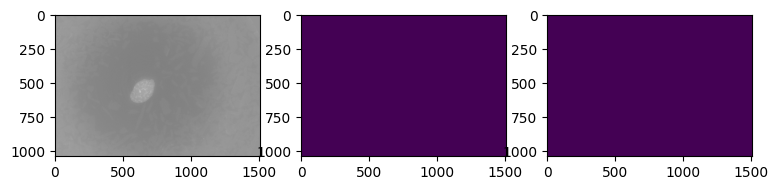

torch.Size([3, 1041, 1511])
torch.Size([6, 1, 800, 800])


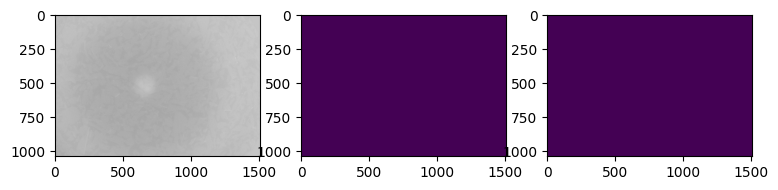

torch.Size([3, 1041, 1511])
torch.Size([6, 1, 800, 800])


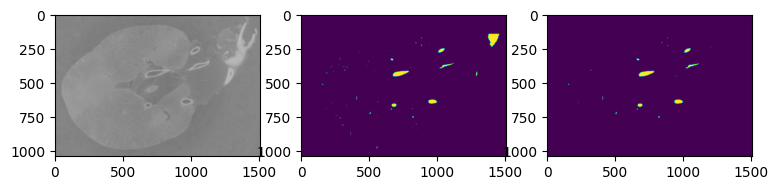

torch.Size([3, 1041, 1511])
torch.Size([6, 1, 800, 800])


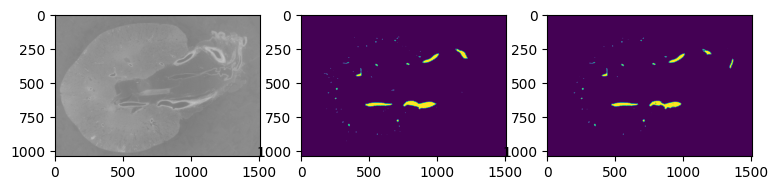

torch.Size([3, 1041, 1511])
torch.Size([6, 1, 800, 800])


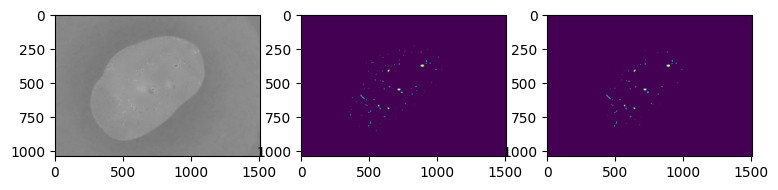

torch.Size([3, 1041, 1511])
torch.Size([6, 1, 800, 800])


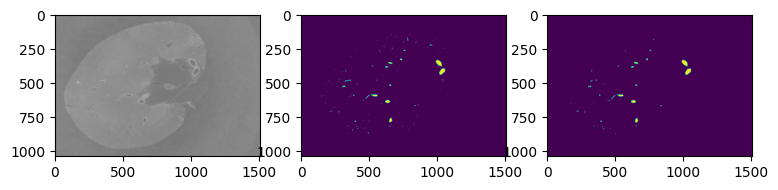

torch.Size([3, 1041, 1511])
torch.Size([6, 1, 800, 800])


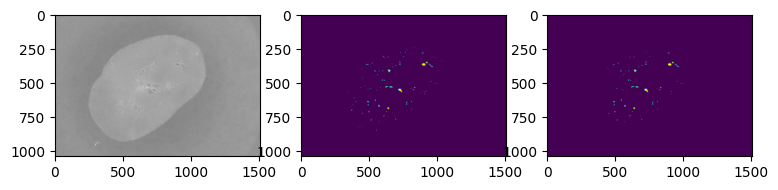

torch.Size([3, 1041, 1511])
torch.Size([6, 1, 800, 800])


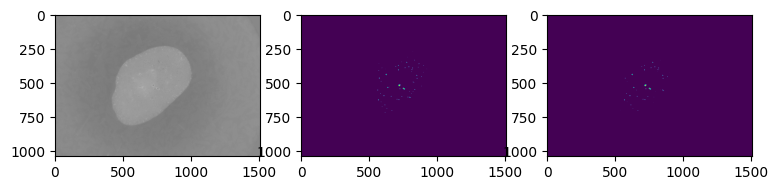

torch.Size([3, 1041, 1511])
torch.Size([6, 1, 800, 800])


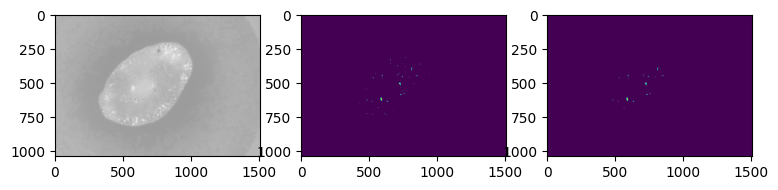

torch.Size([3, 1041, 1511])
torch.Size([6, 1, 800, 800])


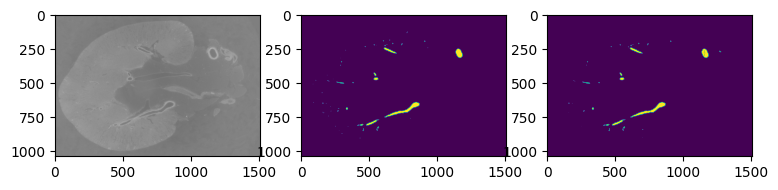

torch.Size([3, 1041, 1511])
torch.Size([6, 1, 800, 800])


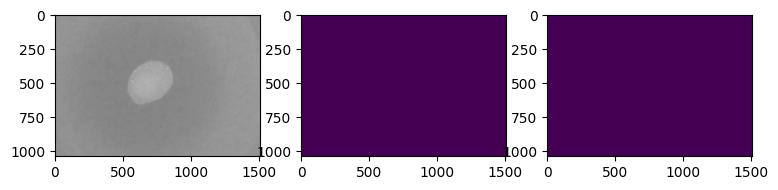

torch.Size([3, 1041, 1511])
torch.Size([6, 1, 800, 800])


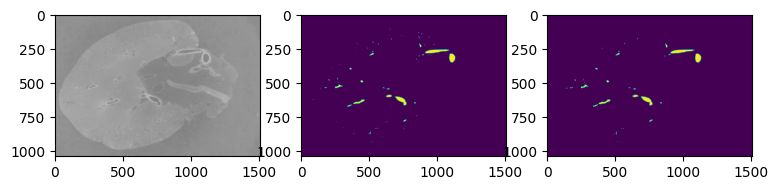

torch.Size([3, 1041, 1511])
torch.Size([6, 1, 800, 800])


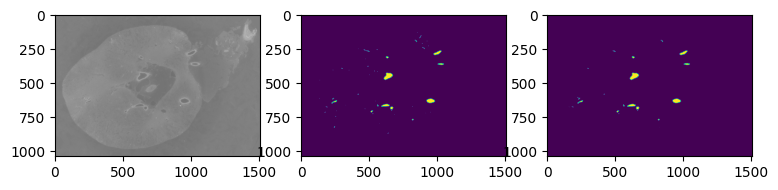

torch.Size([3, 1041, 1511])
torch.Size([6, 1, 800, 800])


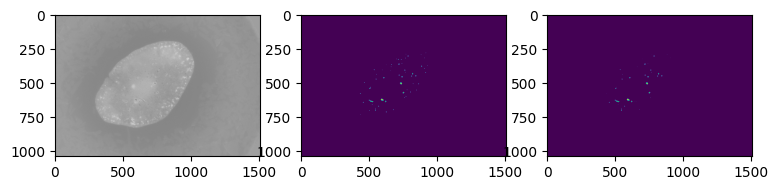

torch.Size([3, 1041, 1511])
torch.Size([6, 1, 800, 800])


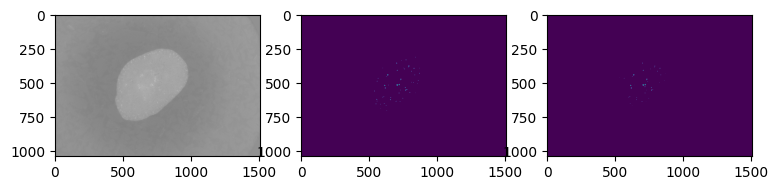

torch.Size([3, 1041, 1511])
torch.Size([6, 1, 800, 800])


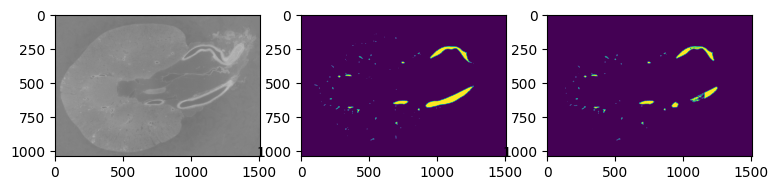

torch.Size([3, 1041, 1511])
torch.Size([6, 1, 800, 800])


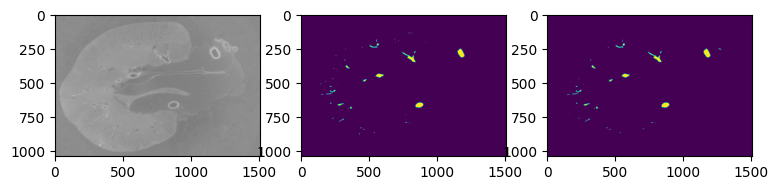

torch.Size([3, 1041, 1511])
torch.Size([6, 1, 800, 800])


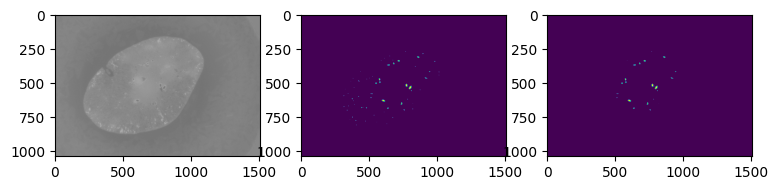

In [15]:
sample_ids = [random.randint(0, len(sanity_dataset)) for _ in range(20)]
for id in sample_ids:
    images, mask = sanity_dataset[id]
    images = images.to(device, dtype=torch.float)
    with torch.no_grad():
        
        print(np.shape(images))
        image = images.unsqueeze(0)
        ori_shape = image.shape
        patches = patch_image(image,patch_size = CFG.patch_size,model = model,over_lap = CFG.over_lap)
        print(patches.shape)
        pred  = combine_patches_torch(patches,ori_shape,patch_size = CFG.patch_size,over_lap = CFG.over_lap )
        pred = (nn.Sigmoid()(pred)>.5).float()
        pred = pred.cpu().numpy().astype(np.uint8)
        plt.figure(figsize=(9, 4))
        plt.subplot(1,3,1)
        image = image.cpu().detach().numpy()
        image = image.squeeze(0)
        image = np.transpose(image,(1,2,0))
        plt.imshow(image)
        plt.subplot(1,3,2)
        plt.imshow(mask)
        plt.subplot(1,3,3)
        pred = pred.squeeze()
        plt.imshow(pred)
        plt.show()
    

# # for images, shapes in test_loader:
# # #     print(np.shape(images))
# #     shapes = shapes.numpy()
# #     images = images.to(device, dtype=torch.float)
# #     with torch.no_grad():
# #         ori_shape = images.shape
# # #         print(ori_shape)
# #         image = images[0]
# #         patches = patch_image(images,512,model = model)
# #         pred  = combine_patches_torch(patches,ori_shape,512)
# #         pred = (nn.Sigmoid()(pred)>.5).float()
# #         pred = pred.cpu().numpy().astype(np.uint8)
# #         plt.figure(figsize=(9, 4))
# #         plt.subplot(1,2,1)
# #         image = image.cpu().detach().numpy()
# #         image = np.transpose(image,(1,2,0))
# #         plt.imshow(image)
# #         plt.subplot(1,2,2)
# #         pred = pred.squeeze()
# #         plt.imshow(pred)

In [16]:
ids = []
for p_img in tqdm(ls_images):
    path_ = p_img.split(os.path.sep)
    # parse the submission ID
    dataset = path_[-3]
    slice_id, _ = os.path.splitext(path_[-1])
    ids.append(f"{dataset}_{slice_id}")

100%|██████████| 6/6 [00:00<00:00, 34239.22it/s]


In [17]:
submission = pd.DataFrame.from_dict({
    "id": ids,
    "rle": rles
})
submission.to_csv("submission.csv", index=False)

In [18]:
submission

,id,rle
0,kidney_5_0001,1 0
1,kidney_5_0002,1 0
2,kidney_5_0000,1 0
3,kidney_6_0001,1 0
4,kidney_6_0002,1 0
5,kidney_6_0000,1 0
